In [5]:
import sys
curr_dir ='/home/users/maali/Computer_vision_SOC'
source ='/home/users/maali/Computer_vision_SOC/source'
sys.path.append(curr_dir)
sys.path.append(source)

import sys
import os
from Preprocessor import Preprocessor
from Sampler import Sampler 
from ObjectDetection import ObjectDetector 
from imageProcessor import ImageProcessor 

from ultralytics import YOLO


########################################Data Preparation######################################################

train_image_folder = curr_dir+'/data/images/train/'
val_image_folder = curr_dir+'/data/images/val/'
test_image_folder = curr_dir+'/data/images/test/'
train_data_csv = curr_dir+'/backup/labels/train.csv'
test_data_csv = curr_dir+'/backup/labels/val.csv'

processor = Preprocessor(train_image_folder,val_image_folder,train_data_csv,test_data_csv)
all_labels = processor.all_labels

train_data_pd,test_data_pd = processor.train_df,processor.val_df
new_train_data_pd,val_data_pd = processor.make_train_val_dfs(train_data_pd)


#move val images to val directory 
processor.move_files_to_val_directory(val_data_pd,source_directory= curr_dir+"/data/images/train",destination_directory =curr_dir+"/data/images/val")

#make labels directories in yolo format
processor.Yolo_labels_maker(new_train_data_pd,curr_dir+'/data/labels/train',skip=True)
processor.Yolo_labels_maker(val_data_pd,curr_dir+'/data/labels/val',skip=True)
processor.Yolo_labels_maker(test_data_pd,curr_dir+'/data/labels/test',skip=True)



########################################Sampling############################################################
sampler = Sampler(new_train_data_pd, val_data_pd, test_data_pd,train=1000,val=300,test=300)
sampler.make_samples(skip=True)

########################################Augmentation########################################################
img_processor = ImageProcessor(sampler.sampled_train_df,sampler.sampled_val_df,sampler.sampled_test_df,)

bg_aug_train_df = img_processor.new_backgrounds_augment(sampler.sampled_train_df,skip=True)
processor.Yolo_labels_maker(bg_aug_train_df,curr_dir+'/samples/train/labels',skip=True,yolo_format=True,keep=True)

########################################Training############################################################

detector = ObjectDetector(data = '/home/users/maali/Computer_vision_SOC/config.yaml')
lrs = [0.01,0.001,0.0001,0.02,0.002]
for lr in lrs:
    detector.train_yolo_model(epochs=150,patience =30,imgsz = 256, batch = 16,lr0=lr ,optimizer = 'SGD') 
                            

validation images already exist, skipping...
training samples made...
validation samples made...
testing samples made...


Ultralytics YOLOv8.0.200 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)


yolo-format labels  made..


engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/home/users/maali/Computer_vision_SOC/config.yaml, epochs=150, patience=30, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=/home/users/maali/Computer_vision_SOC/runs/detect, name=train4, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fal


image 1/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img000167.jpg: 256x256 1 proba_2, 6.2ms
image 2/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img000369.jpg: 256x256 1 proba_2, 6.6ms
image 3/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img000928.jpg: 256x256 1 proba_2, 6.0ms
image 4/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img003607.jpg: 256x256 1 proba_2, 5.8ms
image 5/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img005868.jpg: 256x256 1 proba_2, 5.7ms
image 6/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img010082.jpg: 256x256 1 cheops, 5.7ms
image 7/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img011565.jpg: 256x256 1 cheops, 5.7ms
image 8/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img011674.jpg: 256x256 1 cheops, 5.8ms
image 9/55 /home/users/maali/Computer_vision_SOC/samples/test/images/img015668.jpg: 256x256 1 cheops, 5.7ms
image 10/55 /home/user

Displaying images for class: cheops


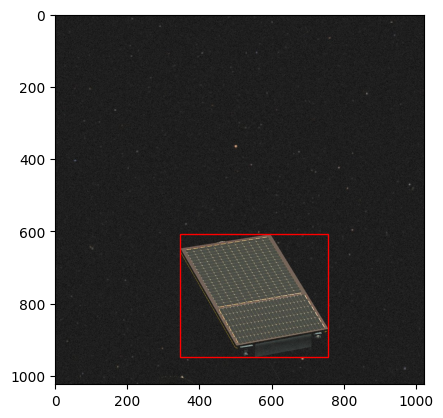

Displaying images for class: debris


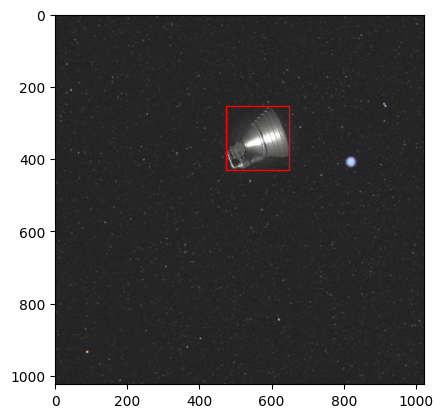

Displaying images for class: double_star


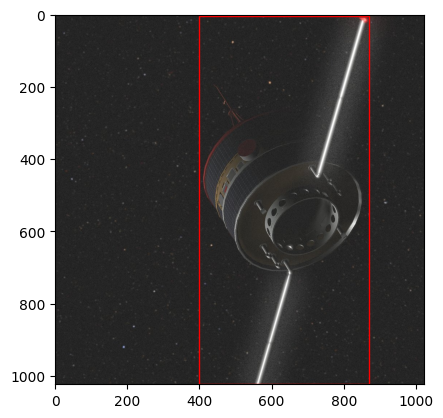

Displaying images for class: earth_observation_sat_1


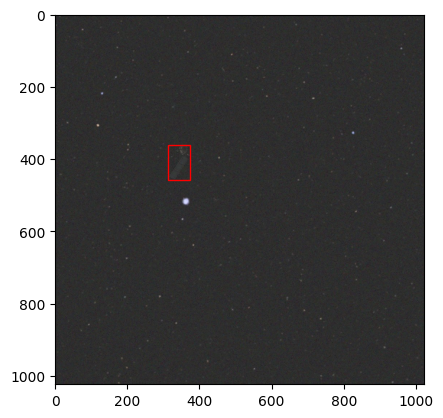

Displaying images for class: lisa_pathfinder


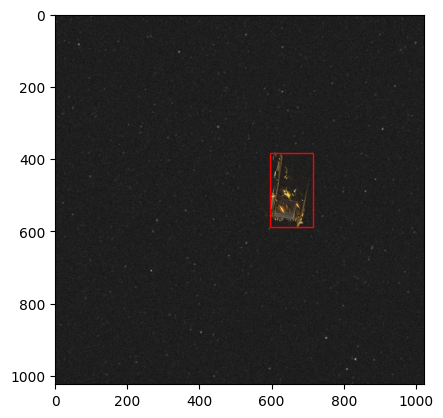

Displaying images for class: proba_2


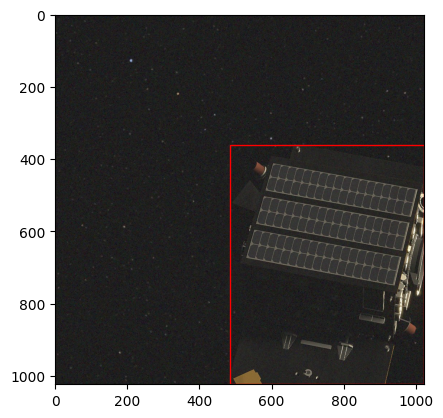

Displaying images for class: proba_3_csc


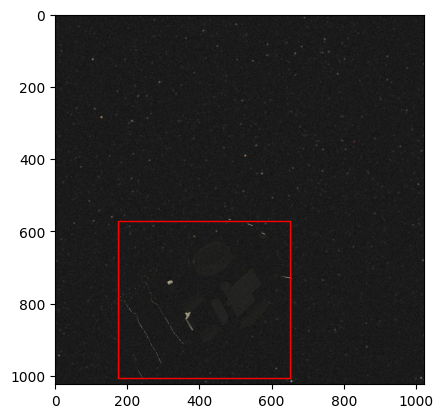

Displaying images for class: proba_3_ocs


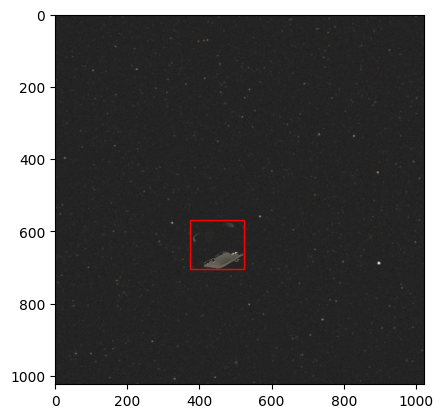

Displaying images for class: smart_1


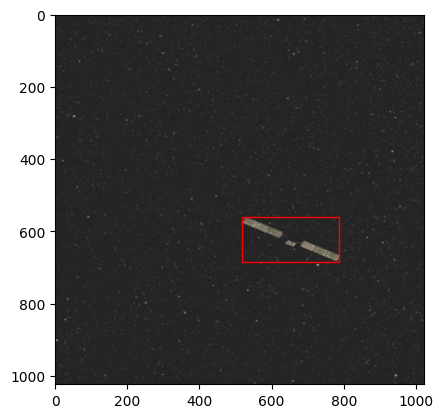

Displaying images for class: soho


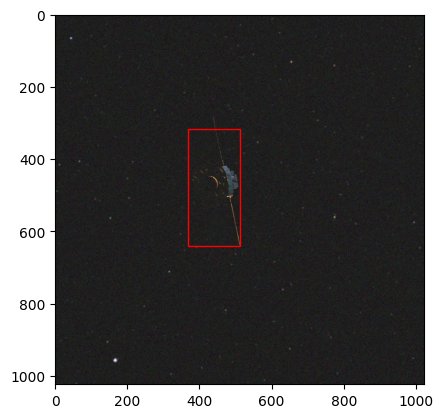

Displaying images for class: xmm_newton


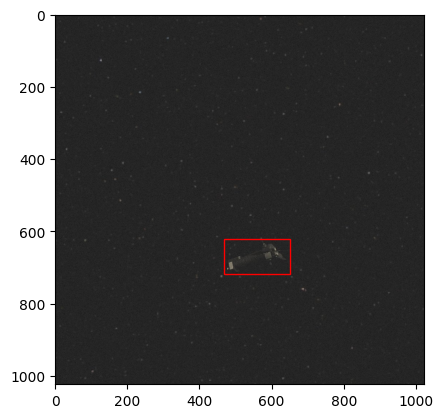

In [2]:
test_images = curr_dir+'/samples/test/images'

predictions_df = detector.predict_with_yolo(test_images,all_labels,
                                            model = curr_dir+'/runs/detect/train3/weights/best.pt',
                                            imgsiz=256
                                            )

true_df = test_data_pd[['filename','class','bbox']]
overall_dict,class_wise_stats,merged_df = detector.classification_report(true_df,predictions_df,all_labels)
iou_scores = detector.iou_report(true_df, predictions_df,all_labels)

processor.show_image_per_class(predictions_df,curr_dir+'/samples/test/images')



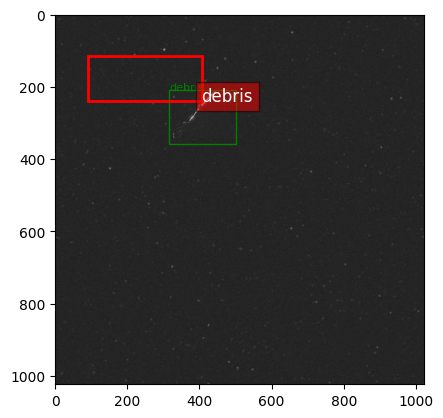

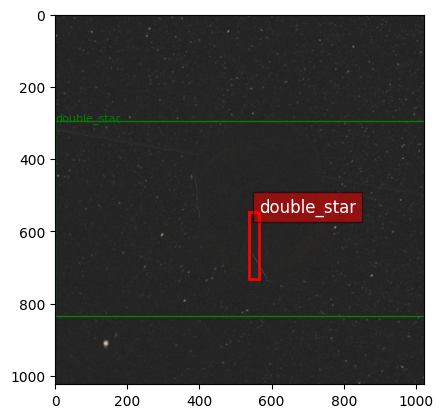

In [3]:
false_positives_df = detector.collect_false_positives(true_df, predictions_df,iou_scores)

detector.show_false_positives(false_positives_df,curr_dir+'/samples/test/images')